# Readability Assessment throughConvolutional Neural Network

Readability assessment is a well known problem in natural language processing field. Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. In this notebook we are trying to assess the readability of a given text regardless of the text subject using recurrent neural network.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [1]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2

# from tensorflow.keras.engine.input_layer import Input

import numpy as np

# glove = load_glove_embeddings()
corpus = load_corpus()
articles, tags = corpus_to_words(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [2]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles[i][:words])], 
        ["Intermediate",detokenize(articles[i+2][:words])], 
        ["Elementary",detokenize(articles[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 10px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [3]:
maxlen = 1000 # Cuts off reviews after 100 words
training_samples = 450
validation_samples = 117
max_words = 45
articles, tags = corpus_to_pos(corpus)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles)
print(tokenizer.word_index)
print(len(tokenizer.word_index))


{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}
44


In [4]:
sequences = tokenizer.texts_to_sequences(articles)
# print(sequences)
print(np.shape(sequences))


(567,)


In [5]:

data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
print(data)
print(np.shape(data))

[[23 10 11 ...  0  0  0]
 [23 10 11 ...  0  0  0]
 [23 10 11 ...  0  0  0]
 ...
 [ 4  5 21 ...  0  0  0]
 [ 6  5 21 ...  0  0  0]
 [ 4  5 21 ...  0  0  0]]
(567, 1000)


In [6]:
print(np.shape(tags))
labels = to_categorical(tags)
print(np.shape(labels))

(567,)
(567, 3)


In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(indices[0])
print(np.shape(data), np.shape(labels), np.shape(data[0]))

x_train= data[:training_samples]
y_train= labels[:training_samples]
print(np.shape(x_train), np.shape(y_train))

x_val =data[training_samples:]
y_val =labels[training_samples:]
print(np.shape(x_val), np.shape(y_val))
from tensorflow.python import keras


124
(567, 1000) (567, 3) (1000,)
(450, 1000) (450, 3)
(117, 1000) (117, 3)


In [58]:
data = data.reshape(data.shape[0], data.shape[1], 1)
model = Sequential()
model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.1, l2=0.1)))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
# model.summary()

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='acc',patience=10, verbose=1, mode='auto')
callbacks = [keras.callbacks.TensorBoard(log_dir='my_log_dir',histogram_freq=1)]
model.compile(optimizer=RMSprop(),
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit(data, labels,
epochs=1000,  
batch_size=50,
validation_split=0.2,
callbacks=callbacks)
model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 453 samples, validate on 114 samples
Epoch 1/1000
453/453 [==============================] - 1s 2ms/step - loss: 7.8648 - acc: 0.3355 - val_loss: 6.8571 - val_acc: 0.3596
Epoch 2/1000
453/453 [==============================] - 0s 218us/step - loss: 6.7026 - acc: 0.3135 - val_loss: 8.7858 - val_acc: 0.3158
Epoch 3/1000
453/453 [==============================] - 0s 205us/step - loss: 6.6745 - acc: 0.3267 - val_loss: 6.5028 - val_acc: 0.3070
Epoch 4/1000
453/453 [==============================] - 0s 210us/step - loss: 6.2386 - acc: 0.3400 - val_loss: 6.7274 - val_acc: 0.3333
Epoch 5/1000
453/453 [==============================] - 0s 202us/step - loss: 5.9772 - acc: 0.3841 - val_loss: 6.9859 - val_acc: 0.3246
Epoch 6/1000
453/453 [==============================] - 0s 204us/step - loss: 5.8211 - acc: 0.3753 - val_loss: 6.1359 - val_acc: 0.3509
Epoch 7/1000
453/453 [==============================] - 0s 200us/step - loss: 5.6113 - acc: 0.4172 - val_loss: 6.4521 - val_acc: 0.3246
Epoc

453/453 [==============================] - 0s 210us/step - loss: 1.6339 - acc: 0.4834 - val_loss: 1.6161 - val_acc: 0.5088
Epoch 61/1000
453/453 [==============================] - 0s 210us/step - loss: 1.5814 - acc: 0.5055 - val_loss: 1.8408 - val_acc: 0.3158
Epoch 62/1000
453/453 [==============================] - 0s 208us/step - loss: 1.5890 - acc: 0.4857 - val_loss: 1.7024 - val_acc: 0.3246
Epoch 63/1000
453/453 [==============================] - 0s 205us/step - loss: 1.5432 - acc: 0.4967 - val_loss: 1.6094 - val_acc: 0.4386
Epoch 64/1000
453/453 [==============================] - 0s 197us/step - loss: 1.5213 - acc: 0.4702 - val_loss: 1.5868 - val_acc: 0.3333
Epoch 65/1000
453/453 [==============================] - 0s 206us/step - loss: 1.4979 - acc: 0.5011 - val_loss: 1.5263 - val_acc: 0.4474
Epoch 66/1000
453/453 [==============================] - 0s 206us/step - loss: 1.4731 - acc: 0.4834 - val_loss: 1.5403 - val_acc: 0.3333
Epoch 67/1000
453/453 [==============================] 

Epoch 120/1000
453/453 [==============================] - 0s 189us/step - loss: 1.0882 - acc: 0.4768 - val_loss: 1.0860 - val_acc: 0.4737
Epoch 121/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0856 - acc: 0.4570 - val_loss: 1.0822 - val_acc: 0.4825
Epoch 122/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0857 - acc: 0.4327 - val_loss: 1.0769 - val_acc: 0.4561
Epoch 123/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0851 - acc: 0.4481 - val_loss: 1.0755 - val_acc: 0.4825
Epoch 124/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0833 - acc: 0.4636 - val_loss: 1.0884 - val_acc: 0.4737
Epoch 125/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0837 - acc: 0.4592 - val_loss: 1.0830 - val_acc: 0.4737
Epoch 126/1000
453/453 [==============================] - 0s 195us/step - loss: 1.0802 - acc: 0.4945 - val_loss: 1.0809 - val_acc: 0.4474
Epoch 127/1000
453/453 [==========

453/453 [==============================] - 0s 216us/step - loss: 1.0583 - acc: 0.4901 - val_loss: 1.0611 - val_acc: 0.4474
Epoch 180/1000
453/453 [==============================] - 0s 206us/step - loss: 1.0585 - acc: 0.4834 - val_loss: 1.0614 - val_acc: 0.4474
Epoch 181/1000
453/453 [==============================] - 0s 209us/step - loss: 1.0592 - acc: 0.4636 - val_loss: 1.0626 - val_acc: 0.4825
Epoch 182/1000
453/453 [==============================] - 0s 214us/step - loss: 1.0595 - acc: 0.4857 - val_loss: 1.0581 - val_acc: 0.4561
Epoch 183/1000
453/453 [==============================] - 0s 213us/step - loss: 1.0575 - acc: 0.4857 - val_loss: 1.0650 - val_acc: 0.5000
Epoch 184/1000
453/453 [==============================] - 0s 218us/step - loss: 1.0598 - acc: 0.4680 - val_loss: 1.0717 - val_acc: 0.4825
Epoch 185/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0592 - acc: 0.4901 - val_loss: 1.0680 - val_acc: 0.4737
Epoch 186/1000
453/453 [=========================

453/453 [==============================] - 0s 199us/step - loss: 1.0464 - acc: 0.4879 - val_loss: 1.0495 - val_acc: 0.4825
Epoch 239/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0477 - acc: 0.4724 - val_loss: 1.0516 - val_acc: 0.5175
Epoch 240/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0454 - acc: 0.5298 - val_loss: 1.0584 - val_acc: 0.4386
Epoch 241/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0458 - acc: 0.5011 - val_loss: 1.0567 - val_acc: 0.4386
Epoch 242/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0472 - acc: 0.4834 - val_loss: 1.0481 - val_acc: 0.5263
Epoch 243/1000
453/453 [==============================] - 0s 207us/step - loss: 1.0443 - acc: 0.4967 - val_loss: 1.0487 - val_acc: 0.5351
Epoch 244/1000
453/453 [==============================] - 0s 187us/step - loss: 1.0438 - acc: 0.5121 - val_loss: 1.0503 - val_acc: 0.4912
Epoch 245/1000
453/453 [=========================

453/453 [==============================] - 0s 212us/step - loss: 1.0403 - acc: 0.5497 - val_loss: 1.0573 - val_acc: 0.5351
Epoch 298/1000
453/453 [==============================] - 0s 212us/step - loss: 1.0451 - acc: 0.5254 - val_loss: 1.0491 - val_acc: 0.4825
Epoch 299/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0388 - acc: 0.5232 - val_loss: 1.0511 - val_acc: 0.5000
Epoch 300/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0405 - acc: 0.5055 - val_loss: 1.0438 - val_acc: 0.5614
Epoch 301/1000
453/453 [==============================] - 0s 197us/step - loss: 1.0361 - acc: 0.5188 - val_loss: 1.0513 - val_acc: 0.5088
Epoch 302/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0382 - acc: 0.5099 - val_loss: 1.0430 - val_acc: 0.5439
Epoch 303/1000
453/453 [==============================] - 0s 197us/step - loss: 1.0382 - acc: 0.4945 - val_loss: 1.0439 - val_acc: 0.5439
Epoch 304/1000
453/453 [=========================

453/453 [==============================] - 0s 217us/step - loss: 1.0300 - acc: 0.5143 - val_loss: 1.0516 - val_acc: 0.5702
Epoch 357/1000
453/453 [==============================] - 0s 216us/step - loss: 1.0330 - acc: 0.5232 - val_loss: 1.0430 - val_acc: 0.4912
Epoch 358/1000
453/453 [==============================] - 0s 222us/step - loss: 1.0296 - acc: 0.4989 - val_loss: 1.0507 - val_acc: 0.5439
Epoch 359/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0307 - acc: 0.5254 - val_loss: 1.0615 - val_acc: 0.4298
Epoch 360/1000
453/453 [==============================] - 0s 197us/step - loss: 1.0302 - acc: 0.5430 - val_loss: 1.0524 - val_acc: 0.4561
Epoch 361/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0313 - acc: 0.5254 - val_loss: 1.0435 - val_acc: 0.5000
Epoch 362/1000
453/453 [==============================] - 0s 207us/step - loss: 1.0295 - acc: 0.4989 - val_loss: 1.0434 - val_acc: 0.5088
Epoch 363/1000
453/453 [=========================

453/453 [==============================] - 0s 200us/step - loss: 1.0280 - acc: 0.5121 - val_loss: 1.0498 - val_acc: 0.4561
Epoch 416/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0252 - acc: 0.5276 - val_loss: 1.0512 - val_acc: 0.5702
Epoch 417/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0277 - acc: 0.5475 - val_loss: 1.0439 - val_acc: 0.5263
Epoch 418/1000
453/453 [==============================] - 0s 190us/step - loss: 1.0242 - acc: 0.5143 - val_loss: 1.0492 - val_acc: 0.5263
Epoch 419/1000
453/453 [==============================] - 0s 188us/step - loss: 1.0287 - acc: 0.5099 - val_loss: 1.0419 - val_acc: 0.5263
Epoch 420/1000
453/453 [==============================] - 0s 167us/step - loss: 1.0260 - acc: 0.5166 - val_loss: 1.0439 - val_acc: 0.5088
Epoch 421/1000
453/453 [==============================] - 0s 167us/step - loss: 1.0270 - acc: 0.5232 - val_loss: 1.0496 - val_acc: 0.5088
Epoch 422/1000
453/453 [=========================

453/453 [==============================] - 0s 200us/step - loss: 1.0197 - acc: 0.5077 - val_loss: 1.0470 - val_acc: 0.5175
Epoch 475/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0217 - acc: 0.5121 - val_loss: 1.0552 - val_acc: 0.5175
Epoch 476/1000
453/453 [==============================] - 0s 200us/step - loss: 1.0198 - acc: 0.5254 - val_loss: 1.0475 - val_acc: 0.4737
Epoch 477/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0210 - acc: 0.5188 - val_loss: 1.0561 - val_acc: 0.5000
Epoch 478/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0206 - acc: 0.5232 - val_loss: 1.0488 - val_acc: 0.4912
Epoch 479/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0208 - acc: 0.5342 - val_loss: 1.0405 - val_acc: 0.5088
Epoch 480/1000
453/453 [==============================] - 0s 188us/step - loss: 1.0198 - acc: 0.5342 - val_loss: 1.0453 - val_acc: 0.5351
Epoch 481/1000
453/453 [=========================

453/453 [==============================] - 0s 212us/step - loss: 1.0170 - acc: 0.5210 - val_loss: 1.0535 - val_acc: 0.4825
Epoch 534/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0234 - acc: 0.5077 - val_loss: 1.0441 - val_acc: 0.5351
Epoch 535/1000
453/453 [==============================] - 0s 183us/step - loss: 1.0160 - acc: 0.5232 - val_loss: 1.0462 - val_acc: 0.5439
Epoch 536/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0167 - acc: 0.5342 - val_loss: 1.0416 - val_acc: 0.5175
Epoch 537/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0127 - acc: 0.5475 - val_loss: 1.0759 - val_acc: 0.4298
Epoch 538/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0197 - acc: 0.5475 - val_loss: 1.0393 - val_acc: 0.5088
Epoch 539/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0174 - acc: 0.5254 - val_loss: 1.0385 - val_acc: 0.5263
Epoch 540/1000
453/453 [=========================

453/453 [==============================] - 0s 198us/step - loss: 1.0139 - acc: 0.5364 - val_loss: 1.0369 - val_acc: 0.5351
Epoch 593/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0146 - acc: 0.5232 - val_loss: 1.0532 - val_acc: 0.4386
Epoch 594/1000
453/453 [==============================] - 0s 197us/step - loss: 1.0131 - acc: 0.5364 - val_loss: 1.0569 - val_acc: 0.4737
Epoch 595/1000
453/453 [==============================] - 0s 190us/step - loss: 1.0173 - acc: 0.5210 - val_loss: 1.0447 - val_acc: 0.4825
Epoch 596/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0155 - acc: 0.5475 - val_loss: 1.0543 - val_acc: 0.4737
Epoch 597/1000
453/453 [==============================] - 0s 203us/step - loss: 1.0138 - acc: 0.5210 - val_loss: 1.0492 - val_acc: 0.5175
Epoch 598/1000
453/453 [==============================] - 0s 200us/step - loss: 1.0131 - acc: 0.5276 - val_loss: 1.0397 - val_acc: 0.5263
Epoch 599/1000
453/453 [=========================

453/453 [==============================] - 0s 194us/step - loss: 1.0107 - acc: 0.5453 - val_loss: 1.0430 - val_acc: 0.5175
Epoch 652/1000
453/453 [==============================] - 0s 203us/step - loss: 1.0059 - acc: 0.5298 - val_loss: 1.0639 - val_acc: 0.5263
Epoch 653/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0200 - acc: 0.5188 - val_loss: 1.0447 - val_acc: 0.5439
Epoch 654/1000
453/453 [==============================] - 0s 194us/step - loss: 1.0084 - acc: 0.5276 - val_loss: 1.0519 - val_acc: 0.4649
Epoch 655/1000
453/453 [==============================] - 0s 200us/step - loss: 1.0102 - acc: 0.5453 - val_loss: 1.0403 - val_acc: 0.5088
Epoch 656/1000
453/453 [==============================] - 0s 187us/step - loss: 1.0115 - acc: 0.5232 - val_loss: 1.0406 - val_acc: 0.5526
Epoch 657/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0095 - acc: 0.5320 - val_loss: 1.0696 - val_acc: 0.4474
Epoch 658/1000
453/453 [=========================

453/453 [==============================] - 0s 194us/step - loss: 1.0086 - acc: 0.5364 - val_loss: 1.0434 - val_acc: 0.5263
Epoch 711/1000
453/453 [==============================] - 0s 194us/step - loss: 1.0093 - acc: 0.5342 - val_loss: 1.0597 - val_acc: 0.4737
Epoch 712/1000
453/453 [==============================] - 0s 204us/step - loss: 1.0104 - acc: 0.5386 - val_loss: 1.0452 - val_acc: 0.5263
Epoch 713/1000
453/453 [==============================] - 0s 195us/step - loss: 1.0084 - acc: 0.5364 - val_loss: 1.0458 - val_acc: 0.4912
Epoch 714/1000
453/453 [==============================] - 0s 198us/step - loss: 1.0091 - acc: 0.5386 - val_loss: 1.0643 - val_acc: 0.4123
Epoch 715/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0081 - acc: 0.5519 - val_loss: 1.0385 - val_acc: 0.5175
Epoch 716/1000
453/453 [==============================] - 0s 203us/step - loss: 1.0123 - acc: 0.5276 - val_loss: 1.0344 - val_acc: 0.6053
Epoch 717/1000
453/453 [=========================

453/453 [==============================] - 0s 202us/step - loss: 1.0064 - acc: 0.5453 - val_loss: 1.0344 - val_acc: 0.5439
Epoch 770/1000
453/453 [==============================] - 0s 196us/step - loss: 1.0059 - acc: 0.5298 - val_loss: 1.0310 - val_acc: 0.5439
Epoch 771/1000
453/453 [==============================] - 0s 193us/step - loss: 1.0037 - acc: 0.5408 - val_loss: 1.0427 - val_acc: 0.5088
Epoch 772/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0054 - acc: 0.5563 - val_loss: 1.0382 - val_acc: 0.5351
Epoch 773/1000
453/453 [==============================] - 0s 202us/step - loss: 1.0035 - acc: 0.5408 - val_loss: 1.0487 - val_acc: 0.5175
Epoch 774/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0084 - acc: 0.5386 - val_loss: 1.0318 - val_acc: 0.5526
Epoch 775/1000
453/453 [==============================] - 0s 190us/step - loss: 1.0081 - acc: 0.5320 - val_loss: 1.0406 - val_acc: 0.5175
Epoch 776/1000
453/453 [=========================

453/453 [==============================] - 0s 203us/step - loss: 1.0074 - acc: 0.5342 - val_loss: 1.0347 - val_acc: 0.5877
Epoch 829/1000
453/453 [==============================] - 0s 218us/step - loss: 1.0030 - acc: 0.5364 - val_loss: 1.0341 - val_acc: 0.5175
Epoch 830/1000
453/453 [==============================] - 0s 213us/step - loss: 1.0018 - acc: 0.5143 - val_loss: 1.0430 - val_acc: 0.4912
Epoch 831/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0009 - acc: 0.5430 - val_loss: 1.0531 - val_acc: 0.5263
Epoch 832/1000
453/453 [==============================] - 0s 210us/step - loss: 1.0123 - acc: 0.5320 - val_loss: 1.0419 - val_acc: 0.5175
Epoch 833/1000
453/453 [==============================] - 0s 216us/step - loss: 1.0049 - acc: 0.5386 - val_loss: 1.0477 - val_acc: 0.4912
Epoch 834/1000
453/453 [==============================] - 0s 206us/step - loss: 1.0055 - acc: 0.5364 - val_loss: 1.0338 - val_acc: 0.5789
Epoch 835/1000
453/453 [=========================

453/453 [==============================] - 0s 204us/step - loss: 1.0079 - acc: 0.5629 - val_loss: 1.0394 - val_acc: 0.5351
Epoch 888/1000
453/453 [==============================] - 0s 212us/step - loss: 1.0027 - acc: 0.5364 - val_loss: 1.0366 - val_acc: 0.5702
Epoch 889/1000
453/453 [==============================] - 0s 212us/step - loss: 0.9990 - acc: 0.5364 - val_loss: 1.0488 - val_acc: 0.4561
Epoch 890/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0011 - acc: 0.5276 - val_loss: 1.0428 - val_acc: 0.5088
Epoch 891/1000
453/453 [==============================] - 0s 206us/step - loss: 1.0095 - acc: 0.5430 - val_loss: 1.0655 - val_acc: 0.4561
Epoch 892/1000
453/453 [==============================] - 0s 209us/step - loss: 1.0033 - acc: 0.5475 - val_loss: 1.0323 - val_acc: 0.5702
Epoch 893/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0000 - acc: 0.5342 - val_loss: 1.0408 - val_acc: 0.5088
Epoch 894/1000
453/453 [=========================

453/453 [==============================] - 0s 206us/step - loss: 1.0036 - acc: 0.5475 - val_loss: 1.0403 - val_acc: 0.5088
Epoch 947/1000
453/453 [==============================] - 0s 204us/step - loss: 1.0009 - acc: 0.5585 - val_loss: 1.0392 - val_acc: 0.5000
Epoch 948/1000
453/453 [==============================] - 0s 203us/step - loss: 1.0010 - acc: 0.5298 - val_loss: 1.0414 - val_acc: 0.5175
Epoch 949/1000
453/453 [==============================] - 0s 203us/step - loss: 1.0052 - acc: 0.5408 - val_loss: 1.0352 - val_acc: 0.5088
Epoch 950/1000
453/453 [==============================] - 0s 201us/step - loss: 1.0013 - acc: 0.5298 - val_loss: 1.0686 - val_acc: 0.4737
Epoch 951/1000
453/453 [==============================] - 0s 199us/step - loss: 1.0095 - acc: 0.5298 - val_loss: 1.0365 - val_acc: 0.5439
Epoch 952/1000
453/453 [==============================] - 0s 209us/step - loss: 1.0018 - acc: 0.5607 - val_loss: 1.0435 - val_acc: 0.5000
Epoch 953/1000
453/453 [=========================

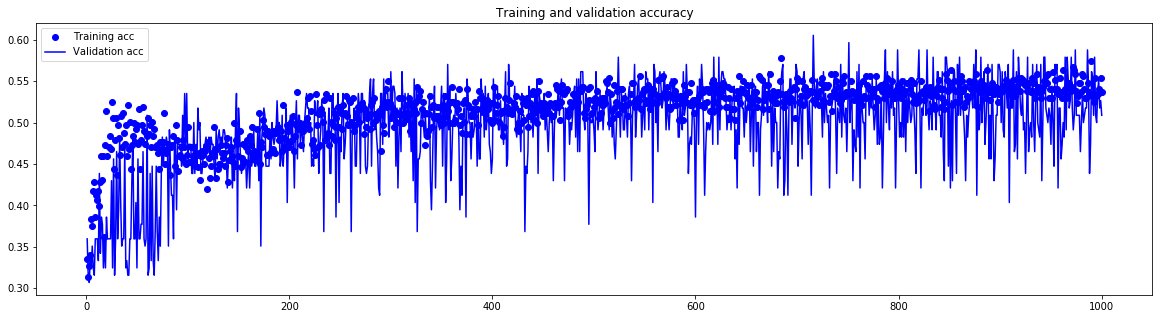

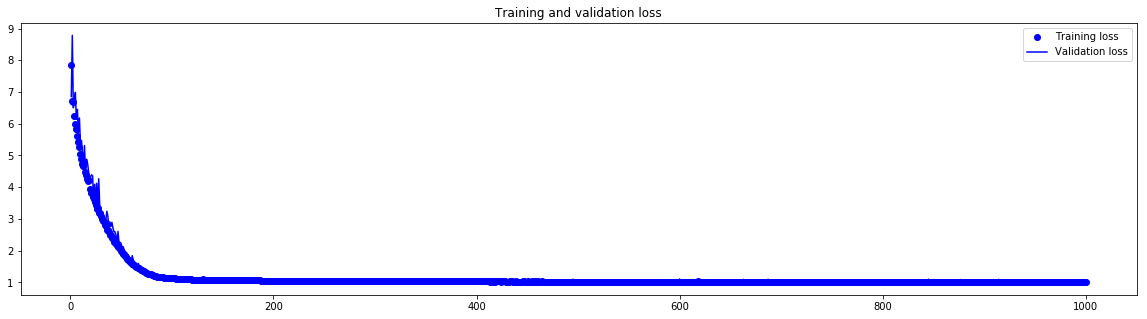

In [60]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(20,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




In [62]:
result = model.evaluate(data, labels)
print(result[1])

567/567 [==============================] - 0s 82us/step
0.5361552030321152
